In [1]:
import pandas as pd
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt

import psycopg2;

In [2]:
conn = psycopg2.connect(dbname='COMPG011', host='127.0.0.1', user='postgres', password='password')
cur = conn.cursor()

## Removing Outliers

In [100]:
# Perform a new query with logic to remove outliers
# People with more headshots than total kills,
# more than 9 kills per round,
# and more than 4,000,000 headshots are removed (3946 total)
# This is an average of 5 kills in a 2 minute game * 12 hours/day * 365days/year * 6 years

cur.execute('''SELECT a.user_id, a.total_kills_headshot, b.total_rounds
                FROM csgo.profiles a, 
                    (SELECT user_id, sum(total_rounds) AS total_rounds 
                    FROM csgo.maps_stats
                    GROUP BY user_id) b
                WHERE a.user_id = b.user_id
                AND a.total_kills_headshot IS NOT NULL
                AND a.total_kills / 9 <= b.total_rounds
                AND a.total_kills_headshot <= a.total_kills
                AND a.total_kills_headshot < 4000000''')

rows = cur.fetchall()
col_names = [desc.name for desc in cur.description]

df = pd.DataFrame(rows, columns = col_names)
headshots = np.flip(np.sort(df['total_kills_headshot']), axis=0)

## Calculate moments
### Jacknife
`c` is the number of splits created in the dataset. 10 is recommended by the slides.

In [95]:
c = 10
arrays = np.array_split(np.random.permutation(headshots), c)
indices = np.arange(c)

means = []
variances = []
skews = []
kurtoses = []

for i in indices:
    l_prime = np.concatenate([arrays[j] for j in indices if j != i])
    
    means.append(np.mean(l_prime))
    variances.append(np.var(l_prime))
    skews.append(scipy.stats.skew(l_prime))
    kurtoses.append(scipy.stats.kurtosis(l_prime))

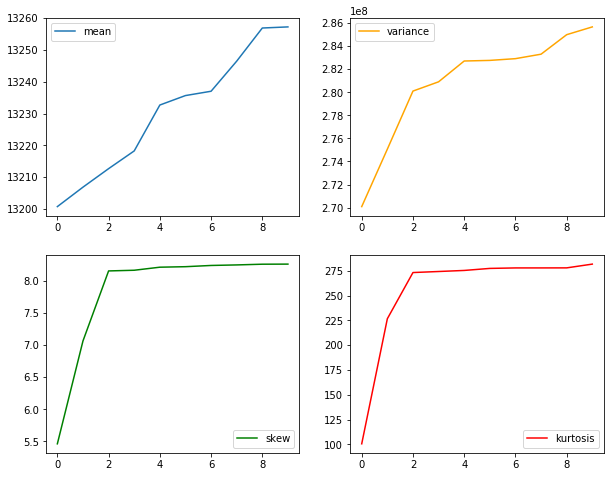

In [96]:
# Setup plot
fig = plt.figure(1, figsize=(10,8))

ax = fig.add_subplot(2, 2, 1, label='plot1')
plt.plot(np.sort(means), label='mean')
plt.legend()

ax = fig.add_subplot(2, 2, 2, label='plot2')
plt.plot(np.sort(variances), color='orange', label='variance')
plt.legend()

ax = fig.add_subplot(2, 2, 3, label='plot3')
plt.plot(np.sort(skews), color='green', label='skew')
plt.legend()

ax = fig.add_subplot(2, 2, 4, label='plot4')
plt.plot(np.sort(kurtoses), color='red', label='kurtosis')
plt.legend()

plt.show()

### Bootstrap
`b` is the number of random draws from the dataset.
`m` is the size of the random draws.

In [110]:
b = 10000
m = len(headshots)

means = []
variances = []
skews = []
kurtoses = []

for i in range(b):
    l_prime = np.random.choice(headshots, size=m, replace=True)
    
    means.append(np.mean(l_prime))
    variances.append(np.var(l_prime))
    skews.append(scipy.stats.skew(l_prime))
    kurtoses.append(scipy.stats.kurtosis(l_prime))
    
means = np.sort(means)
variances = np.sort(variances)
skews = np.sort(skews)
kurtoses = np.sort(kurtoses)

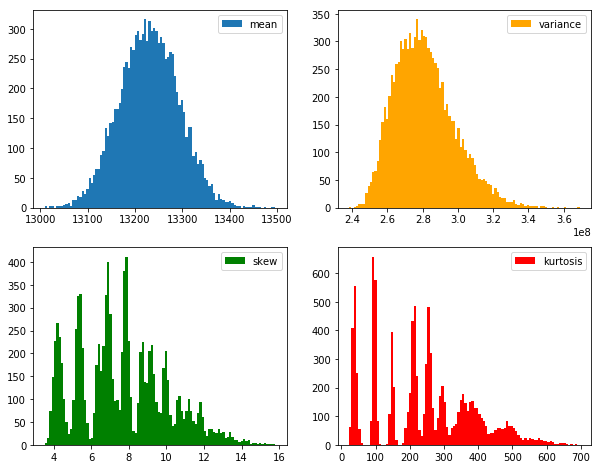

In [111]:
# Setup plot
fig = plt.figure(1, figsize=(10,8))

ax = fig.add_subplot(2, 2, 1, label='plot1')
plt.hist(means, bins=100, label='mean')
plt.legend()

ax = fig.add_subplot(2, 2, 2, label='plot2')
plt.hist(variances, bins=100, color='orange', label='variance')
plt.legend()

ax = fig.add_subplot(2, 2, 3, label='plot3')
plt.hist(skews, bins=100, color='green', label='skew')
plt.legend()

ax = fig.add_subplot(2, 2, 4, label='plot4')
plt.hist(kurtoses, bins=100, color='red', label='kurtosis')
plt.legend()

plt.show()

In [114]:
mean_conf_inv = (np.percentile(means, 2.5), np.percentile(means, 97.5))
variance_conf_inv = (np.percentile(variances, 2.5), np.percentile(variances, 97.5))
skew_conf_inv = (np.percentile(skews, 2.5), np.percentile(skews, 97.5))
kurtosis_conf_inv = (np.percentile(kurtoses, 2.5), np.percentile(kurtoses, 97.5))

print('Mean confidence interval: %f %f' %mean_conf_inv)
print('Variance confidence interval: %f %f' %variance_conf_inv)
print('Skew confidence interval: %f %f' %skew_conf_inv)
print('Kurtosis confidence interval: %f %f' %kurtosis_conf_inv)

Mean confidence interval: 13109.104007 13353.033442
Variance confidence interval: 253532298.406831 318779361.201410
Skew confidence interval: 4.012231 12.738504
Kurtosis confidence interval: 32.799541 535.055435


>>Why are the skew and kurtosis multi-modal, is this reasonable, etc?

### Whole dataset

In [101]:
mean = np.mean(headshots)
median = np.median(headshots)
variance = np.var(headshots)
skew = scipy.stats.skew(headshots)
kurtosis = scipy.stats.kurtosis(headshots)

print('Mean: %s' %mean)
print('Median: %s' %median)
print('Variance: %s' %variance)
print('Skew: %s' %skew)
print('Kurtosis: %s' %kurtosis)

Mean: 13230.4418553
Median: 8401.0
Variance: 280851486.321
Skew: 7.848041037628898
Kurtosis: 255.8391353222861


## Plot histogram of data against an exponential distribution

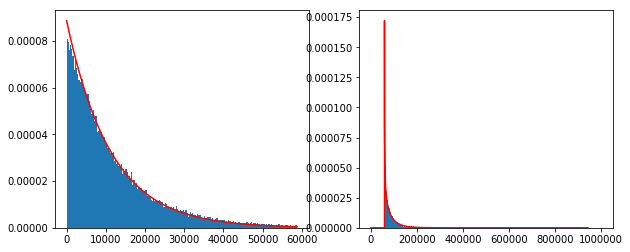

In [106]:
clip_point = 1495
data = headshots[clip_point:]

# Setup plot
fig = plt.figure(1, figsize=(10,4))

# Plot body
ax = fig.add_subplot(1, 2, 1, label='plot5')

# Plot histogram
hist, bin_edges = np.histogram(data, bins=200)
plt.hist(data, bins=bin_edges, normed=True)

# Plot exponential curve
params = scipy.stats.expon.fit(data)

x_axis = np.linspace(min(data), max(data), 10000)
y_axis = scipy.stats.expon.pdf(x_axis, *params)
plt.plot(x_axis, y_axis, color='red')

# Plot tail
ax = fig.add_subplot(1, 2, 2, label='plot6')
data = headshots[:clip_point]

# Plot histogram
hist, bin_edges = np.histogram(data2, bins=200)
plt.hist(data, bins=bin_edges, normed=True)

# Plot chi^2 curve
params = scipy.stats.chi2.fit(data)

x_axis = np.linspace(min(data), max(data), 10000)
y_axis = scipy.stats.chi2.pdf(x_axis - min(data), *params)
plt.plot(x_axis - min(data), y_axis, color='red')

plt.show()

>>Can we plot a Chi^2 distribution for the tail or is that not allowed?

## Plot rank-frequency (log-log) of data
The plot is overlaid with a exponential distribution and the tail has been fit with a Chi^2 distribution.

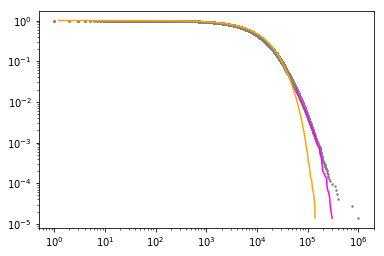

In [105]:
data_sorted = np.sort(headshots)
rank = np.flip(np.arange(1, len(data_sorted) + 1), axis=0) / (len(data_sorted) + 1)

# Setup plot
fig = plt.figure(1)
ax = fig.add_subplot(1, 1, 1, label='plot6')

# Plot points
plt.scatter(data_sorted, rank, color='gray', s=2)

# Plot exponential
params = scipy.stats.expon.fit(data_sorted)
x_axis = np.sort(scipy.stats.expon.rvs(*params, len(rank)))

ax.set_xscale('log')
ax.set_yscale('log')
plt.plot(x_axis, rank, color='orange')

# Plot tail
clip_start = 1495

lin_data = data_sorted[-clip_start:]
lin_rank = rank[-clip_start:]

params = scipy.stats.chi2.fit(lin_data)
x_axis = np.sort(scipy.stats.chi2.rvs(*params, len(lin_rank)))

plt.plot(x_axis, lin_rank, color='fuchsia')

plt.show()

## Find the clipping point in between the body and the tail
Utilising the KS test

In [26]:
data_sorted = np.sort(headshots)

ks_values = []
for clip_count in range(1, 10000):
    clipped_data = data_sorted[:-clip_count]
    
    params = scipy.stats.expon.fit(clipped_data)
    kst = scipy.stats.kstest(clipped_data, 'expon', params)
    
    ks_values.append((clip_count, kst))
        
    if clip_count % 100 == 0:
        print('Finished iteration %i, %s' %(clip_count, kst))

Finished iteration 100, KstestResult(statistic=0.031431602376167822, pvalue=6.7164826804390311e-65)
Finished iteration 200, KstestResult(statistic=0.027936965187159546, pvalue=2.7204875466805443e-51)
Finished iteration 300, KstestResult(statistic=0.025075342567118686, pvalue=2.3778893697746144e-41)
Finished iteration 400, KstestResult(statistic=0.022569831595349088, pvalue=1.5495745602808779e-33)
Finished iteration 500, KstestResult(statistic=0.020296082158027584, pvalue=3.6416952909652005e-27)
Finished iteration 600, KstestResult(statistic=0.018198206615199219, pvalue=6.7952954216199633e-22)
Finished iteration 700, KstestResult(statistic=0.016245984355553245, pvalue=1.6376744881269646e-17)
Finished iteration 800, KstestResult(statistic=0.014400804158466451, pvalue=7.81951207794213e-14)
Finished iteration 900, KstestResult(statistic=0.012661225525778474, pvalue=8.9273255975577361e-11)
Finished iteration 1000, KstestResult(statistic=0.01101624723888861, pvalue=2.9924499752743404e-08)
Fi

KeyboardInterrupt: 

## Plot the statistics calculated above

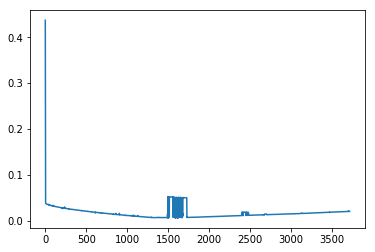

In [32]:
plt.plot(range(1, len(ks_values) + 1), list(map(lambda x: x.statistic, list(zip(*ks_values))[1])))
plt.show()

In [29]:
data_sorted = np.sort(data)

anderson_values = []
for clip_count in range(1, 10000):
    clipped_data = data_sorted[:-clip_count]

    anderson = scipy.stats.anderson(clipped_data, 'expon')
    
    anderson_values.append((clip_count, anderson))
        
    if clip_count % 100 == 0:
        print('Finished iteration %i, %s' %(clip_count, anderson))

Finished iteration 100, AndersonResult(statistic=10.766516035437235, critical_values=array([ 0.922,  1.078,  1.341,  1.606,  1.957]), significance_level=array([ 15. ,  10. ,   5. ,   2.5,   1. ]))
Finished iteration 200, AndersonResult(statistic=9.9131003848888213, critical_values=array([ 0.922,  1.078,  1.341,  1.606,  1.957]), significance_level=array([ 15. ,  10. ,   5. ,   2.5,   1. ]))
Finished iteration 300, AndersonResult(statistic=9.7688345867500175, critical_values=array([ 0.922,  1.078,  1.341,  1.606,  1.957]), significance_level=array([ 15. ,  10. ,   5. ,   2.5,   1. ]))
Finished iteration 400, AndersonResult(statistic=10.250134921006975, critical_values=array([ 0.922,  1.078,  1.341,  1.606,  1.957]), significance_level=array([ 15. ,  10. ,   5. ,   2.5,   1. ]))
Finished iteration 500, AndersonResult(statistic=11.260672550371964, critical_values=array([ 0.922,  1.078,  1.341,  1.606,  1.957]), significance_level=array([ 15. ,  10. ,   5. ,   2.5,   1. ]))
Finished iterat

Finished iteration 4300, AndersonResult(statistic=206.08973031873757, critical_values=array([ 0.922,  1.078,  1.341,  1.606,  1.957]), significance_level=array([ 15. ,  10. ,   5. ,   2.5,   1. ]))
Finished iteration 4400, AndersonResult(statistic=212.64235835449654, critical_values=array([ 0.922,  1.078,  1.341,  1.606,  1.957]), significance_level=array([ 15. ,  10. ,   5. ,   2.5,   1. ]))
Finished iteration 4500, AndersonResult(statistic=219.24967041004857, critical_values=array([ 0.922,  1.078,  1.341,  1.606,  1.957]), significance_level=array([ 15. ,  10. ,   5. ,   2.5,   1. ]))
Finished iteration 4600, AndersonResult(statistic=225.89585505527793, critical_values=array([ 0.922,  1.078,  1.341,  1.606,  1.957]), significance_level=array([ 15. ,  10. ,   5. ,   2.5,   1. ]))
Finished iteration 4700, AndersonResult(statistic=232.58856543809816, critical_values=array([ 0.922,  1.078,  1.341,  1.606,  1.957]), significance_level=array([ 15. ,  10. ,   5. ,   2.5,   1. ]))
Finished i

Finished iteration 8500, AndersonResult(statistic=490.62783968553413, critical_values=array([ 0.922,  1.078,  1.341,  1.606,  1.957]), significance_level=array([ 15. ,  10. ,   5. ,   2.5,   1. ]))
Finished iteration 8600, AndersonResult(statistic=497.22215231967857, critical_values=array([ 0.922,  1.078,  1.341,  1.606,  1.957]), significance_level=array([ 15. ,  10. ,   5. ,   2.5,   1. ]))
Finished iteration 8700, AndersonResult(statistic=503.75073473034718, critical_values=array([ 0.922,  1.078,  1.341,  1.606,  1.957]), significance_level=array([ 15. ,  10. ,   5. ,   2.5,   1. ]))
Finished iteration 8800, AndersonResult(statistic=510.23503863820224, critical_values=array([ 0.922,  1.078,  1.341,  1.606,  1.957]), significance_level=array([ 15. ,  10. ,   5. ,   2.5,   1. ]))
Finished iteration 8900, AndersonResult(statistic=516.70488425726944, critical_values=array([ 0.922,  1.078,  1.341,  1.606,  1.957]), significance_level=array([ 15. ,  10. ,   5. ,   2.5,   1. ]))
Finished i

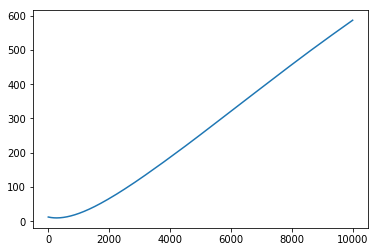

In [31]:
plt.plot(range(1, len(anderson_values) + 1), list(map(lambda x: x.statistic, list(zip(*anderson_values))[1])))
plt.show()

In [31]:
ks_min = sorted(ks_values, key=lambda x: x[1].statistic)[0]
anderson_min = sorted(anderson_values, key=lambda x: x[1].statistic)[0]

print('KS minimum: %i, %f' %(ks_min[0], ks_min[1].statistic))
print('Anderson minimum: %i, %f' %(anderson_min[0], anderson_min[1].statistic))

KS minimum: 1495, 0.005668
Anderson minimum: 342, 6.443042


## Show differences in mean and median headshots based on player rank

In [110]:
cur.execute('''SELECT a.id, b.total_kills_headshot FROM csgo.ranks a, csgo.profiles b 
                WHERE a.id = b.rank_id AND 
                        b.total_kills_headshot IS NOT NULL AND
                        b.total_kills_headshot <= b.total_kills
                ORDER BY b.total_kills_headshot DESC''')

rows = cur.fetchall()
col_names = [desc.name for desc in cur.description]

In [113]:
df = pd.DataFrame(rows, columns = col_names)

In [112]:
for i in range(1, 19):
    print("Rank %i: median %f, mean %f" %(i, np.median(df[df.id == i].total_kills_headshot), np.mean(df[df.id == i].total_kills_headshot)))

Rank 1: median 952.000000, mean 2371.569729
Rank 2: median 2240.000000, mean 3067.677348
Rank 3: median 2620.000000, mean 3746.041815
Rank 4: median 2982.000000, mean 18692.984609
Rank 5: median 3437.000000, mean 4449.990172
Rank 6: median 3899.000000, mean 35314.383014
Rank 7: median 4656.500000, mean 5859.850202
Rank 8: median 5487.000000, mean 6933.175837
Rank 9: median 6224.000000, mean 7616.107580
Rank 10: median 7285.000000, mean 9281.824201
Rank 11: median 8781.000000, mean 22555.872724
Rank 12: median 10076.000000, mean 198340.401729
Rank 13: median 11630.000000, mean 208269.876726
Rank 14: median 13300.500000, mean 382442.064652
Rank 15: median 15661.000000, mean 40436.170927
Rank 16: median 18419.000000, mean 307587.264569
Rank 17: median 22041.000000, mean 26348.679380
Rank 18: median 30037.000000, mean 37910.376481
